In [1]:
import json_lines
from langdetect import detect
from langdetect import detect_langs
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.neural_network import MLPClassifier
import numpy as np
import threading
import time
import random

from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

ALL_TAGS= ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT',
 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
 'WP$', 'WRB']
ACCEPTABLE_TAGS= ['FW', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS',
 'POS', 'RB', 'RBR', 'RBS', 'RP', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WP$']

MAX_FEATURES= 400 # incrasing this grants marginal increases in accuracy at the cost of run time
MIN_ENGLISH= 0.999
LIMIT_INPUT_ROWS= 300 # You won't get as many rows of data in the final result as many are filtered out. Having this as <500 seems to impact the model's accuracy
K_FOLDS= 10
WNL = WordNetLemmatizer()

number_entries= 0
with open ('reviews.json', 'rb') as f:
    for item in json_lines.reader(f):
        number_entries+= 1

In [2]:
# READ IN INFO
reviews= []; polarity= []; are_early= []
included_indexs= []
j= 0
while j < LIMIT_INPUT_ROWS:
    randint= random.randint(0, number_entries-1)
    if not randint in included_indexs:
        included_indexs.append(randint)
        j+= 1
    
with open('reviews.json', 'rb') as f: # 5,000 entries in reviews.json
    for counter, item in enumerate(json_lines.reader(f)):
        if counter in included_indexs:
            reviews.append(item['text'])
            polarity.append(item['voted_up'])
            are_early.append(item['early_access'])

# END PRODUCTS: reviews, polarity, are_early

In [3]:
# FILTER TEXT BY LANGUAGE

filtered_reviews= []
filtered_polarity= []
filtered_are_early= []
for i, text in enumerate(reviews):
    try:
        langs = detect_langs(text)
    except:
        pass
    for lang in langs:
        if str(lang)[0:2] == 'en':
            if float(str(lang)[3:]) > MIN_ENGLISH:
                filtered_reviews.append(reviews[i])
                filtered_polarity.append(polarity[i])
                filtered_are_early.append(are_early[i])
reviews= filtered_reviews
polarity= filtered_polarity
are_early= filtered_are_early

In [4]:
# FILTER TEXT BY WORD TYPE

#print(reviews)
filtered_reviews= []
for i, text in enumerate(reviews):
    #print("-------------------------------------")
    new_text= []
    split_text= text.split()
    tags= nltk.pos_tag(split_text)
    #print(tags)
    #print("#############")
    lemd_split_text= []
    for word in split_text:
        lemd_split_text.append(WNL.lemmatize(word))
    tags= nltk.pos_tag(lemd_split_text)
    #print(tags)
    for j, word in enumerate(lemd_split_text):
        if tags[j][1] in ACCEPTABLE_TAGS:
            new_text.append(word)
    filtered_reviews.append(new_text)
reviews= [' '.join([str(elem) for elem in sublist]) for sublist in filtered_reviews]
#print(reviews)

In [5]:
# MOST FREQ WORDS AS FEATURES
word_counts = {}
for text in reviews:
    for word in text.split():
        if word in word_counts:
            word_counts[word]+= 1
        else:
            word_counts[word]= 1
word_counts= {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}
trimd_word_counts= {}
for i, entry in enumerate(word_counts):
    if i >= MAX_FEATURES:
        break
    trimd_word_counts[entry]= word_counts[entry]

# END PRODUCTS: trimd_word_counts

In [6]:
# CREATE 1-HOT ENCODINGS
amount_features= MAX_FEATURES
one_hots= []
for text in reviews:
    one_hot= []
    for i in range(MAX_FEATURES):
        one_hot.append(0)
    for word in text.split():
        if word in trimd_word_counts:
            one_hot[list(trimd_word_counts).index(word)]+= 1
    one_hots.append(one_hot)

for i, one_hot in enumerate(one_hots): # convert array of lists into 2d array
    one_hot_arr = np.array(one_hot)
    one_hots[i] = one_hot_arr
    print(one_hot)

x= np.array(one_hots)
y= np.array(polarity, dtype=np.int)

# END PRODUCTS: x, y

[0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

0.5977272727272727


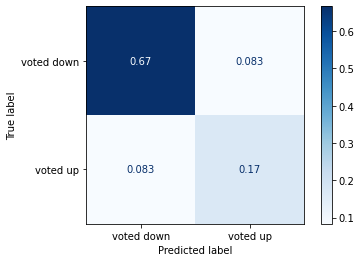

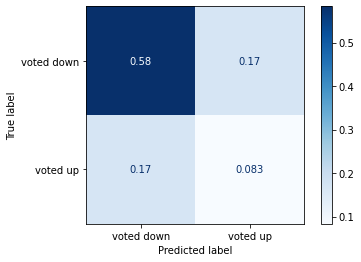

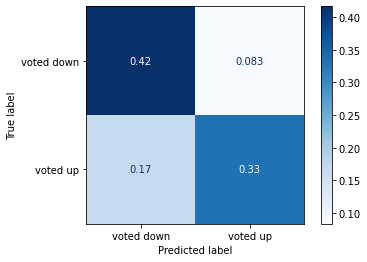

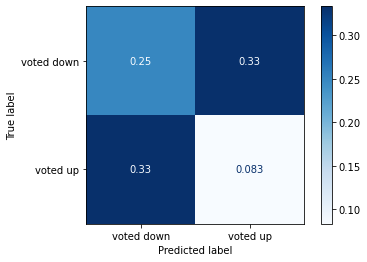

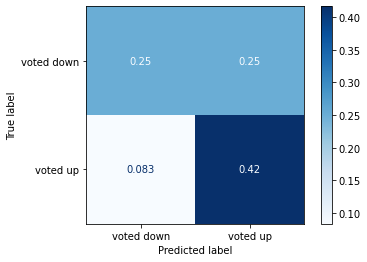

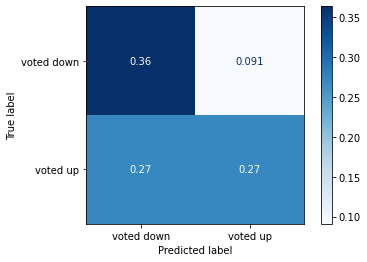

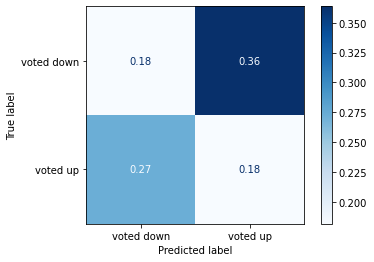

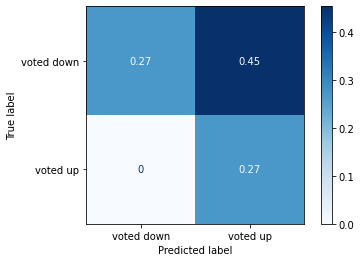

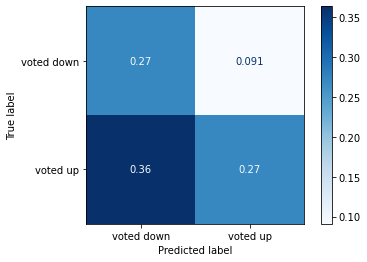

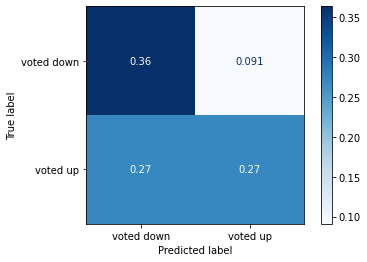

In [7]:
# SPLIT, TRAIN, PREDICT, GRAPH
total_score= 0
kfold= KFold(K_FOLDS, shuffle=True, random_state=1)
x_test= []
y_test= []
x_train= []
y_train= []
for train_index, test_index in kfold.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf= MLPClassifier(hidden_layer_sizes=(amount_features, int(amount_features/2), int(amount_features/4)), activation="identity", solver="adam", random_state=1, alpha=0.0001).fit(x_train, y_train)
    total_score+= clf.score(x_test, y_test)
    try:
        fig= plot_confusion_matrix(clf, x_test, y_test, display_labels=["voted down", "voted up"], cmap=plt.cm.Blues, normalize="all")
    except ValueError:
        pass
print(total_score / K_FOLDS)